# Imports

In [ ]:
import os
import csv
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

import torch
torch.set_printoptions(edgeitems=2, threshold=50)

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np
import pandas as pd
from scipy import signal
import torchaudio

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/deep-learning-summer-2025/FinalProject/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Functions

In [ ]:
BASE_URL = "https://accent.gmu.edu/"
LIST_URL = urljoin(BASE_URL, "browse_language.php?function=find&language=english")

def get_sample_links():
    resp = requests.get(LIST_URL)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, 'html.parser')
    links = []
    # Each sample row is a <tr> with a link inside the first <td>
    for row in soup.find_all('p'):
        link_tag = row.find('a')
        if link_tag:
            link_tag = link_tag['href']
            full_link = urljoin(BASE_URL, link_tag)
            links.append(full_link)
    return links

def get_text_after_em(soup, label):
    for li in soup.find_all('li'):
        em = li.find('em')
        if em and label in em.get_text(strip=True).lower():
            text = li.get_text(strip=True)
            return text.replace(em.get_text(strip=True), '').strip()
    return None

def parse_sample_page(url):
    resp = requests.get(url)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, 'html.parser')
    info = {"url": url}

    # Demographic table
    age_sex = get_text_after_em(soup, "age, sex:")
    residence = get_text_after_em(soup, "english residence:")
    learning_method = get_text_after_em(soup, "english learning method:")
    native_lang = get_text_after_em(soup, "native language:")
    other_lang = get_text_after_em(soup, "other language(s):")
    duration = get_text_after_em(soup, "length of english residence:").split(' ')[0]
    # Further split age and sex
    age, sex = None, None
    if age_sex:
        parts = age_sex.split(',')
        if len(parts) == 2:
            age = parts[0].strip()
            sex = parts[1].strip()

    info['sex'] = sex
    info['age'] = float(age)
    info['country'] = residence
    info['learning_method'] = learning_method
    info['native_language'] = native_lang
    info['other_language'] = other_lang
    info['english_residence_duration'] = float(duration)

    info['transcript'] = soup.find_all('p', attrs="transtext")[0].text

    # Audio link
    audio = soup.find('audio')
    if audio and audio.find('source'):
        info['audio_url'] = urljoin(url, audio.find('source')['src'])
    return info

def download_audio(audio_url, out_folder="SpeechAccentArchive"):
    os.makedirs(out_folder, exist_ok=True)
    fname = os.path.basename(audio_url)
    path = os.path.join(out_folder, fname)
    r = requests.get(audio_url, stream=True)
    r.raise_for_status()
    with open(path, 'wb') as f:
        for chunk in r.iter_content(8192):
            f.write(chunk)
    return path

# Download data from Speech Accent Archive

In [ ]:
samples = get_sample_links()
with open("SpeechAccentArchive/audio_metadata.csv", "w", newline='') as f:
    writer = csv.DictWriter(f, fieldnames=["url","sex","age","country","learning_method","native_language", "other_language", "english_residence_duration","transcript","audio_url","path"])
    writer.writeheader()
    for url in samples:
        try:
            info = parse_sample_page(url)
            path = None
            if info.get("audio_url"):
                path = download_audio(info["audio_url"])
                info["path"] = path
            writer.writerow(info)
            print(f"{url}")
        except Exception as e:
            print(f"Error at {url}: {e}")

https://accent.gmu.edu/browse_language.php?function=detail&speakerid=61
https://accent.gmu.edu/browse_language.php?function=detail&speakerid=77
https://accent.gmu.edu/browse_language.php?function=detail&speakerid=88
https://accent.gmu.edu/browse_language.php?function=detail&speakerid=99
https://accent.gmu.edu/browse_language.php?function=detail&speakerid=110
https://accent.gmu.edu/browse_language.php?function=detail&speakerid=121
https://accent.gmu.edu/browse_language.php?function=detail&speakerid=132
https://accent.gmu.edu/browse_language.php?function=detail&speakerid=143
https://accent.gmu.edu/browse_language.php?function=detail&speakerid=154
https://accent.gmu.edu/browse_language.php?function=detail&speakerid=62
https://accent.gmu.edu/browse_language.php?function=detail&speakerid=68
https://accent.gmu.edu/browse_language.php?function=detail&speakerid=69
https://accent.gmu.edu/browse_language.php?function=detail&speakerid=70
https://accent.gmu.edu/browse_language.php?function=detail&

# Demographics of sample data

Number of samples: 661


/tmp/ipython-input-174-2341294587.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='country_clean', order=df['country_clean'].value_counts().index, palette='viridis')


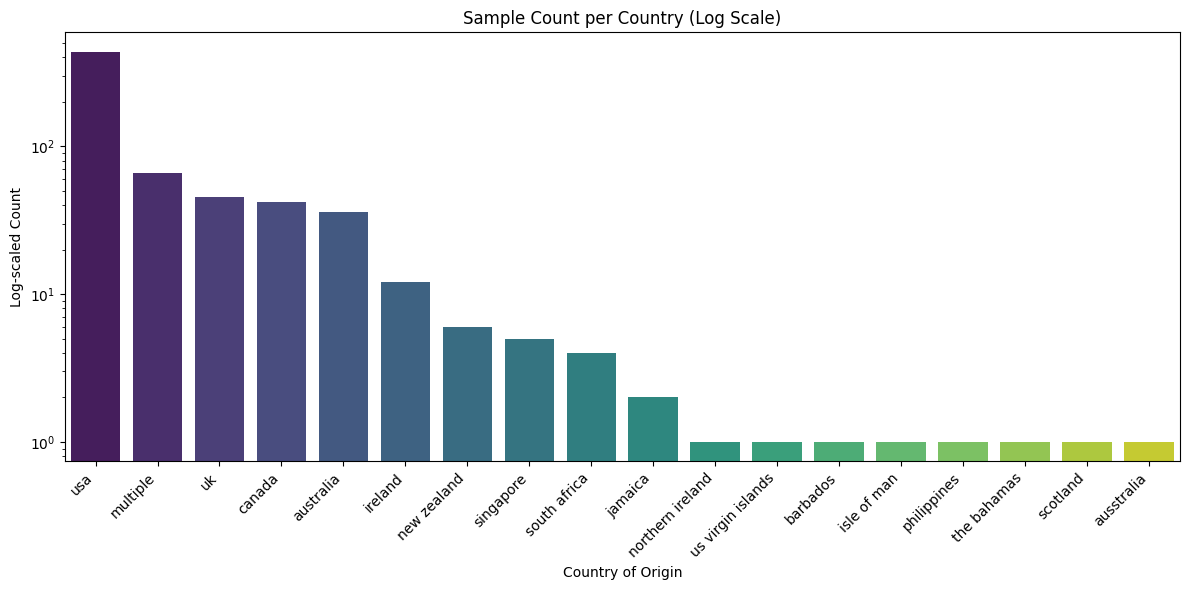

In [ ]:
df = pd.read_csv('SpeechAccentArchive/audio_metadata.csv')
print('Number of samples:', len(df))
country_clean = []
for i, row in df.iterrows():
    if len(row['country'].split(',')) > 1:
      country_clean.append('multiple')
    else:
      country_clean.append(row['country'].lower())
df['country_clean'] = country_clean

import seaborn as sns

plt.figure(figsize=(12, 6))

# Use seaborn's countplot for better handling of categorical counts
sns.countplot(data=df, x='country_clean', order=df['country_clean'].value_counts().index, palette='viridis')
plt.yscale('log')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Country of Origin')
plt.ylabel('Log-scaled Count')
plt.title('Sample Count per Country (Log Scale)')
plt.tight_layout()
plt.show()

In [ ]:
df.iloc

# Read in data

In [ ]:
from pprint import pprint

url = 'https://accent.gmu.edu/browse_language.php?function=detail&speakerid=604'
info = parse_sample_page(url)
path = None
if info.get("audio_url"):
    path = download_audio(info["audio_url"])
    info["path"] = path
pprint(info)

{'age': 38.0,
 'audio_url': 'https://accent.gmu.edu/soundtracks/english185.mp3',
 'country': 'canada',
 'english_residence_duration': 36.0,
 'learning_method': 'naturalistic',
 'native_language': 'english(eng)',
 'other_language': 'spanish',
 'path': 'SpeechAccentArchive/english185.mp3',
 'sex': 'male',
 'transcript': '\r\n'
               'Please call Stella.\xa0 Ask her to bring these things with her '
               'from\r\n'
               '        the store:\xa0 Six spoons of fresh snow peas, five '
               'thick slabs of blue\r\n'
               '        cheese, and maybe a snack for her brother Bob.\xa0 We '
               'also need a small\r\n'
               '        plastic snake and a big toy frog for the kids.\xa0 She '
               'can scoop these\r\n'
               '        things into three red bags, and we will go meet her '
               'Wednesday at the\r\n'
               '        train station.\r\n'
               '        \r\n',
 'url': 'https://acc

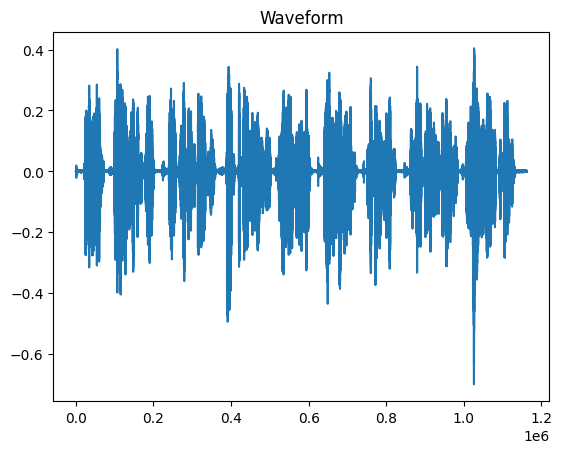

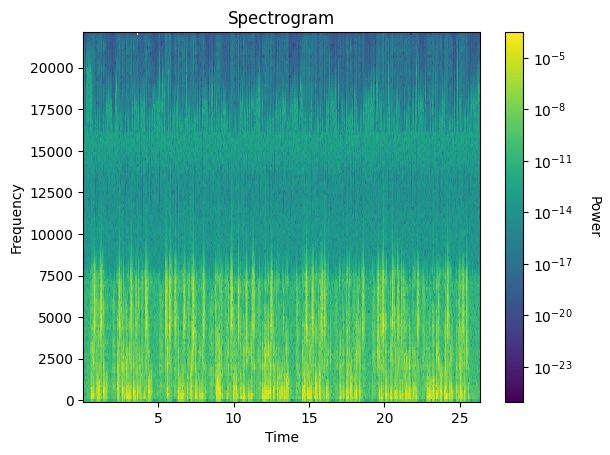

In [ ]:
waveform, freq = torchaudio.load('SpeechAccentArchive/english581.mp3')
waveform_arr = np.array(waveform).flatten()
f_arr, t_arr, sp_arr = signal.spectrogram(waveform_arr, freq)

plt.figure()
plt.plot(waveform_arr)
plt.title('Waveform')
plt.show()

plt.figure()
plt.pcolormesh(t_arr, f_arr, sp_arr, norm=LogNorm())
plt.xlabel('Time')
plt.ylabel('Frequency')
cbar = plt.colorbar()
cbar.set_label('Power', rotation=270, labelpad=20)
plt.title('Spectrogram')
plt.show()